# Model Development for Nuclei Dataset

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.image import resize
from tensorflow.keras.metrics import MeanIoU, Precision, Recall, Accuracy, AUC
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
from helper_functions import display_images, normalize, augment, create_mask, calculate_metrics

## Load Data

In [2]:
# run with saved data on subsequent runs
data = np.load("data/nuclei_data.npz")
images = data["images"]/1.0
masks = np.expand_dims(data["masks"], axis=-1)/1.0
types = data['types']
images, masks, types = shuffle(images, masks, types, random_state=12)

# train/val/test split
train_split = round(len(images) * 0.7)
val_split = round(len(images) * 0.2) + train_split

images_train = images[:train_split]
images_val = images[train_split:val_split]
images_test = images[val_split:]

masks_train = masks[:train_split]
masks_val = masks[train_split:val_split]
masks_test = masks[val_split:]

types_train = types[:train_split]
types_val = types[train_split:val_split]
types_test = types[val_split:]

In [3]:
print("Train masks:", masks_train.shape)
print("Validation masks:", masks_val.shape)
print("Test masks:", masks_test.shape)

Train masks: (4268, 256, 256, 1)
Validation masks: (1219, 256, 256, 1)
Test masks: (610, 256, 256, 1)


In [4]:
print("Total:")
print(np.unique(types, return_counts=True))
print()
print("Train:")
print(np.unique(types_train, return_counts=True))
print()
print("Val:")
print(np.unique(types_val, return_counts=True))
print()
print("Test:")
print(np.unique(types_test, return_counts=True))

Total:
(array(['Adrenal_gland', 'Bile-duct', 'Bladder', 'Breast', 'Cervix',
       'Colon', 'Esophagus', 'HeadNeck', 'Kidney', 'Liver', 'Lung',
       'Ovarian', 'Pancreatic', 'Prostate', 'Skin', 'Stomach', 'Testis',
       'Thyroid', 'Uterus'], dtype='<U13'), array([ 371,  344,   94, 1978,  237,  938,  289,  233,   99,  179,  178,
        129,  148,  130,  146,  120,  162,  160,  162]))

Train:
(array(['Adrenal_gland', 'Bile-duct', 'Bladder', 'Breast', 'Cervix',
       'Colon', 'Esophagus', 'HeadNeck', 'Kidney', 'Liver', 'Lung',
       'Ovarian', 'Pancreatic', 'Prostate', 'Skin', 'Stomach', 'Testis',
       'Thyroid', 'Uterus'], dtype='<U13'), array([ 260,  236,   70, 1385,  158,  648,  201,  162,   75,  123,  127,
         85,  111,   90,  108,   83,  114,  119,  113]))

Val:
(array(['Adrenal_gland', 'Bile-duct', 'Bladder', 'Breast', 'Cervix',
       'Colon', 'Esophagus', 'HeadNeck', 'Kidney', 'Liver', 'Lung',
       'Ovarian', 'Pancreatic', 'Prostate', 'Skin', 'Stomach', 'Testis',
 

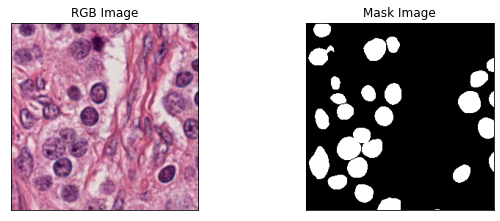

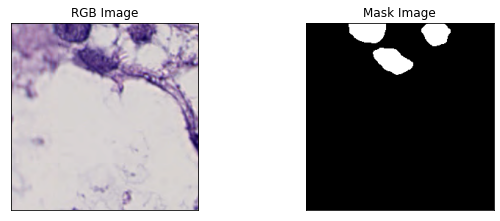

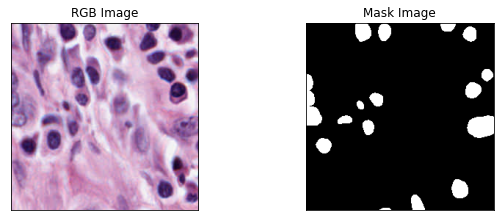

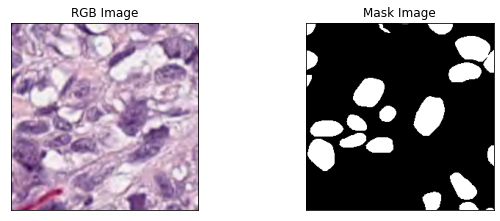

In [5]:
display_images(images_train[0], np.squeeze(masks_train[0]))
display_images(images_train[1], np.squeeze(masks_train[1]))
display_images(images_val[0], np.squeeze(masks_val[0]))
display_images(images_val[1], np.squeeze(masks_val[1]))

## Parameters

In [6]:
EPOCHS = 40
BATCH_SIZE = 64
STEPS_PER_EPOCH = len(images_train) // BATCH_SIZE
VALID_STEPS = len(images_val) // BATCH_SIZE
IMG_SIZE = (128, 128)

In [7]:
# The tf.data pipeline needs to be established in order to input the image and true masks into the model. 
train_set = tf.data.Dataset.from_tensor_slices((images_train, masks_train))
train_set = train_set.map(normalize)
train_set = train_set.batch(BATCH_SIZE).repeat()

valid_set = tf.data.Dataset.from_tensor_slices((images_val, masks_val))
valid_set = valid_set.map(normalize)
valid_set = valid_set.batch(BATCH_SIZE).repeat()

## Architecture

In [8]:
# Pull in ResNet101 for base model
input_layer = layers.Input(shape=(128,128,3), name='input_layer')
base = tf.keras.applications.ResNet101(include_top=False, input_tensor=input_layer, weights='imagenet')

base.trainable = False
print(base.summary())

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_layer[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']     

In [9]:
# Use the activations of these layers for U-Net skip connections
layer_names = [
    'conv1_relu',
    'conv2_block3_2_relu',
    'conv3_block4_2_relu',
    'conv4_block23_2_relu',
    'conv5_block3_2_relu'
]

base_outputs = [base.get_layer(name).output for name in layer_names]
encoder = Model(inputs=base.input, outputs=base_outputs)

encoder.trainable = False
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_layer[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

 conv4_block15_2_conv (Conv2D)  (None, 8, 8, 256)    590080      ['conv4_block15_1_relu[0][0]']   
                                                                                                  
 conv4_block15_2_bn (BatchNorma  (None, 8, 8, 256)   1024        ['conv4_block15_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block15_2_relu (Activati  (None, 8, 8, 256)   0           ['conv4_block15_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block15_3_conv (Conv2D)  (None, 8, 8, 1024)   263168      ['conv4_block15_2_relu[0][0]']   
                                                                                                  
 conv4_blo

In [10]:
# specify skip layers and set up decoder
skips = encoder.outputs
x = skips[-1]
skips = reversed(skips[:-1])

filters = [8, 16, 32, 64]
for i, layer in enumerate(skips):
    # x = layers.UpSampling2D((2,2))(x) # not as accurate as conv transpose
    x = layers.Conv2DTranspose(filters[-(i+1)], (3,3), strides=2, padding='same', activation='relu')(x)
    x = layers.Concatenate()([x, layer])
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(filters[-(i+1)], (3,3), padding='same', activation='relu')(x)
    x = layers.Conv2D(filters[-(i+1)], (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

# final layer of model
x = layers.Conv2DTranspose(1, (3,3), strides=2, padding='same')(x)
x = layers.Activation('sigmoid')(x)

# define inputs and outputs of final model
unet = Model(inputs=input_layer, outputs=x)
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_layer[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

## Train

In [11]:
# compile the model
unet.compile(optimizer=tf.keras.optimizers.Adam(4e-5),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=[Precision(name='precision'), Recall(name='recall'), 'accuracy'])

In [12]:
# train the modified U-Net
history = unet.fit(train_set,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=EPOCHS,
        validation_data=valid_set,
        validation_steps=VALID_STEPS)

Epoch 1/40
66/66 [==============================] - 492s 7s/step - loss: 0.7263 - precision: 0.1755 - recall: 0.5420 - accuracy: 0.5386 - val_loss: 0.7546 - val_precision: 0.1668 - val_recall: 0.3990 - val_accuracy: 0.6126
Epoch 2/40
66/66 [==============================] - 475s 7s/step - loss: 0.6823 - precision: 0.2408 - recall: 0.6782 - accuracy: 0.6167 - val_loss: 0.6783 - val_precision: 0.2156 - val_recall: 0.6287 - val_accuracy: 0.5996
Epoch 3/40
66/66 [==============================] - 587s 9s/step - loss: 0.6462 - precision: 0.2989 - recall: 0.7653 - accuracy: 0.6803 - val_loss: 0.6384 - val_precision: 0.3054 - val_recall: 0.7550 - val_accuracy: 0.6991
Epoch 4/40
66/66 [==============================] - 699s 11s/step - loss: 0.6153 - precision: 0.3530 - recall: 0.8145 - accuracy: 0.7332 - val_loss: 0.6072 - val_precision: 0.3777 - val_recall: 0.8059 - val_accuracy: 0.7626
Epoch 5/40
66/66 [==============================] - 430s 7s/step - loss: 0.5936 - precision: 0.3961 - recal

Epoch 38/40
66/66 [==============================] - 442s 7s/step - loss: 0.3118 - precision: 0.8190 - recall: 0.8417 - accuracy: 0.9341 - val_loss: 0.4160 - val_precision: 0.6707 - val_recall: 0.6378 - val_accuracy: 0.8923
Epoch 39/40
66/66 [==============================] - 484s 7s/step - loss: 0.3059 - precision: 0.8250 - recall: 0.8406 - accuracy: 0.9350 - val_loss: 0.4160 - val_precision: 0.6702 - val_recall: 0.6361 - val_accuracy: 0.8921
Epoch 40/40
66/66 [==============================] - 398s 6s/step - loss: 0.3009 - precision: 0.8289 - recall: 0.8398 - accuracy: 0.9359 - val_loss: 0.4165 - val_precision: 0.6685 - val_recall: 0.6324 - val_accuracy: 0.8916


## Evaluation

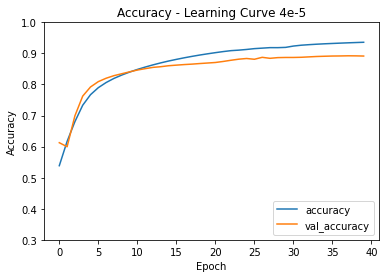

In [13]:
# plot model accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')
plt.title('Accuracy - Learning Curve 4e-5')

plt.show()

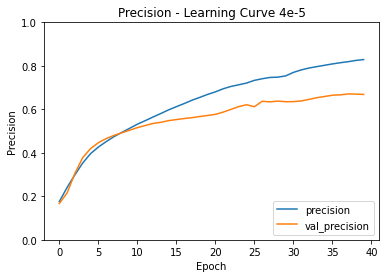

In [14]:
# plot model precision
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label = 'val_precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')
plt.title('Precision - Learning Curve 4e-5')

plt.show()

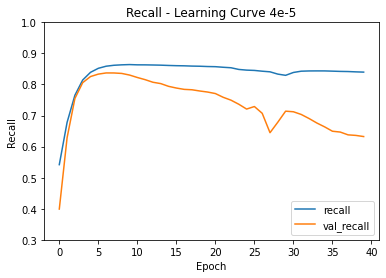

In [15]:
# plot model recall
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label = 'val_recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')
plt.title('Recall - Learning Curve 4e-5')

plt.show()

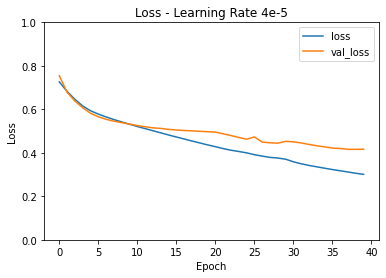

In [16]:
# plot model loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.title('Loss - Learning Rate 4e-5')

plt.show()

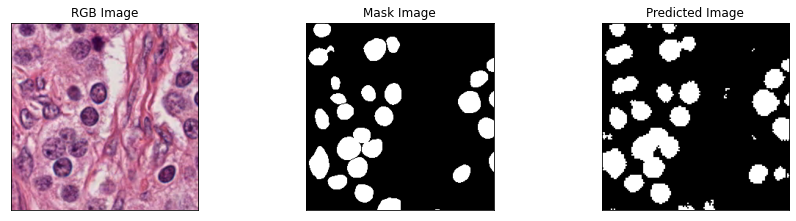

In [17]:
# predict and visualize first train image
i = 0
for image, mask in train_set.take(1):
    pred_mask = unet.predict(image)
    display_images(images_train[i], np.squeeze(masks_train[i]), create_mask(pred_mask, IMG_SIZE))
    i+=1

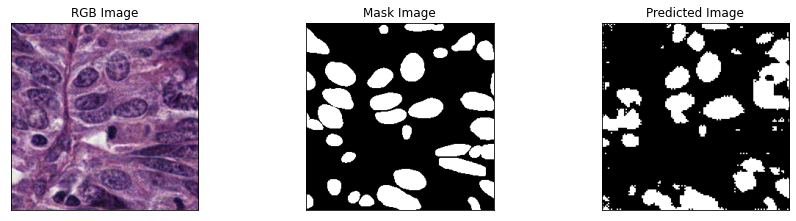

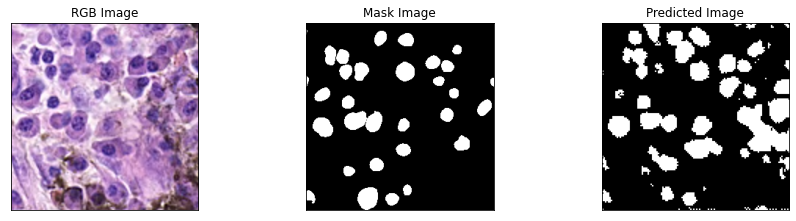

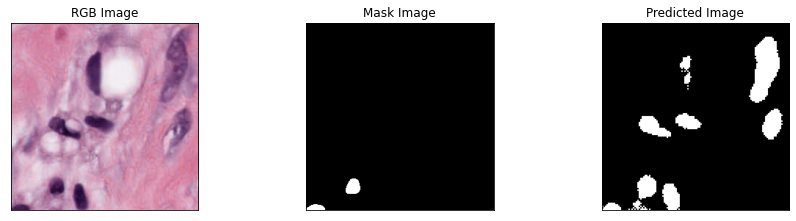

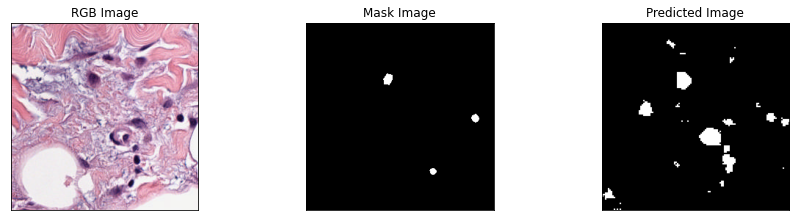

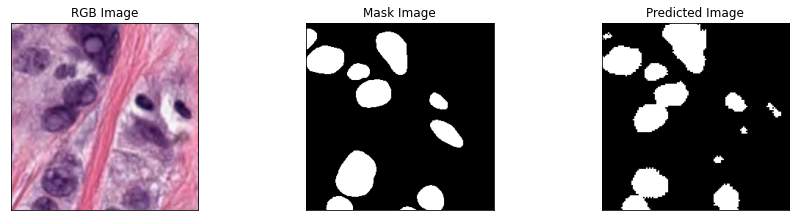

In [18]:
# create tf.data pipeline for test data and show results
test_set = tf.data.Dataset.from_tensor_slices((images_test, masks_test))
test_set = test_set.map(normalize)
test_set = test_set.batch(1)

# predict masks for test images
i=0
for image, mask in test_set.take(5):
    pred_mask = unet.predict(image)
    display_images(images_test[i], np.squeeze(masks_test[i]), create_mask(pred_mask, IMG_SIZE))
    i+=1

In [19]:
# validation metrics:
valid_set = tf.data.Dataset.from_tensor_slices((images_val, masks_val))
valid_set = valid_set.map(normalize)
valid_set = valid_set.batch(1)

val_acc, val_prec, val_recall, val_iou = calculate_metrics(unet, valid_set, IMG_SIZE)

print('Validation Metrics:')
print('Accuracy =', round(val_acc,4))
print('Precision =', round(val_prec,4))
print('Recall =', round(val_recall,4))
print('Mean IoU =', round(val_iou,4))
print()

# test metrics:
test_acc, test_prec, test_recall, test_iou = calculate_metrics(unet, test_set, IMG_SIZE)

print('Test Metrics:')
print('Accuracy =', round(test_acc,4))
print('Precision =', round(test_prec,4))
print('Recall =', round(test_recall,4))
print('Mean IoU =', round(test_iou,4))

Validation Metrics:
Accuracy = 0.8915
Precision = 0.669
Recall = 0.6328
Mean IoU = 0.6834

Test Metrics:
Accuracy = 0.8875
Precision = 0.6675
Recall = 0.6155
Mean IoU = 0.6759


In [20]:
unet.save("model/grouped_128s_4e_5")

INFO:tensorflow:Assets written to: model/grouped_128s_4e_5/assets


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [21]:
np.save('model/grouped_128s_4e_5.npy', history.history)